# Directional Ordinary Kriging

## Table of Contents:

1. Read *meuse* dataset, transform data,
2. Create directional semivariograms,
3. Create directional kriging models,
4. Compare results of interpolation.

## Level: Basic

## Changelog

| Date       | Change description            | Author         | Package Version |
|------------|-------------------------------|----------------|-----------------|
| 2022-11-19 | The first version of tutorial | @SimonMolinsky | 0.3.6           |

## Introduction

In this tutorial, we will learn about Ordinary Kriging with directions. The classic Kriging works with isotropic semivariogram, the similarity between points has the same weights in all directions. Real world geographical data is rarely isotropic, and we distinguish leading directions in spatial processes. The example may be a temperature, where differences in the North-South axis are greater than in the West-East axis.

If you want to learn more about directional processes and semivariograms referr to the tutorial: [Directional semivariograms](https://github.com/DataverseLabs/pyinterpolate/blob/main/tutorials/Directional%20Semivariograms%20(Basic).ipynb).

# 1. Read *meuse* dataset and transform data

We use *meuse* dataset and interpolate zinc concentrations. Dataset is provided by:

<br>

> Pebesma, Edzer. (2009). The meuse data set: a tutorial for the gstat R package -> [link to the publication](https://cran.r-project.org/web/packages/gstat/vignettes/gstat.pdf)

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import pyinterpolate as ptp
from pyinterpolate.variogram.empirical.experimental_variogram import DirectionalVariogram
import matplotlib.pyplot as plt

In [2]:
MEUSE_FILE = 'samples/point_data/csv/meuse/meuse.csv'
MEUSE_GRID = 'samples/point_data/csv/meuse/meuse_grid.csv'

# Variogram parameters
STEP_SIZE = 100
MAX_RANGE = 1600

In [3]:
df = pd.read_csv(MEUSE_FILE, usecols=['x', 'y', 'zinc'])

In [4]:
df.head()

,x,y,zinc
0,181072,333611,1022
1,181025,333558,1141
2,181165,333537,640
3,181298,333484,257
4,181307,333330,269


Let's check the distribution of zinc values:

<AxesSubplot: ylabel='Frequency'>

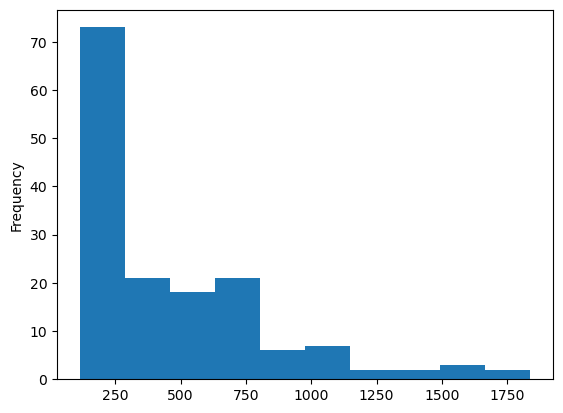

In [5]:
df['zinc'].plot(kind='hist')

Our zinc concentrtations are highly skewed. We should take a natural logarithm of values to make distribution closer to the normal.

In [6]:
df['log-zinc'] = np.log(df['zinc'])

<AxesSubplot: ylabel='Frequency'>

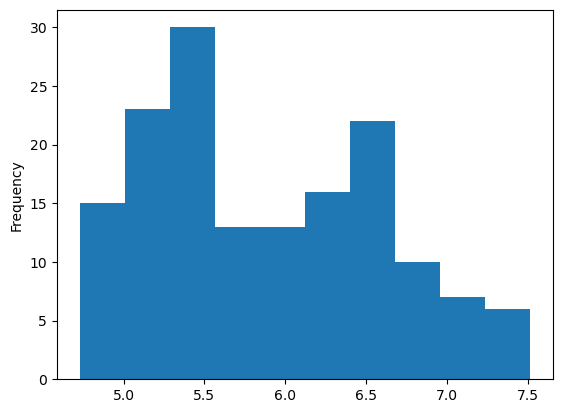

In [7]:
df['log-zinc'].plot(kind='hist')

Histogram is still not close to the normal distribution, it has two modes, but the tail is shorter. We will build models based on this histogram.

## 2. Create directional variograms

Data is prepared, we can model it's semivariance. We will perform an isotropic modeling and a full directional modeling in  *N-S*, *W-E*, *NE-SW*, and *NW-SE* axes.

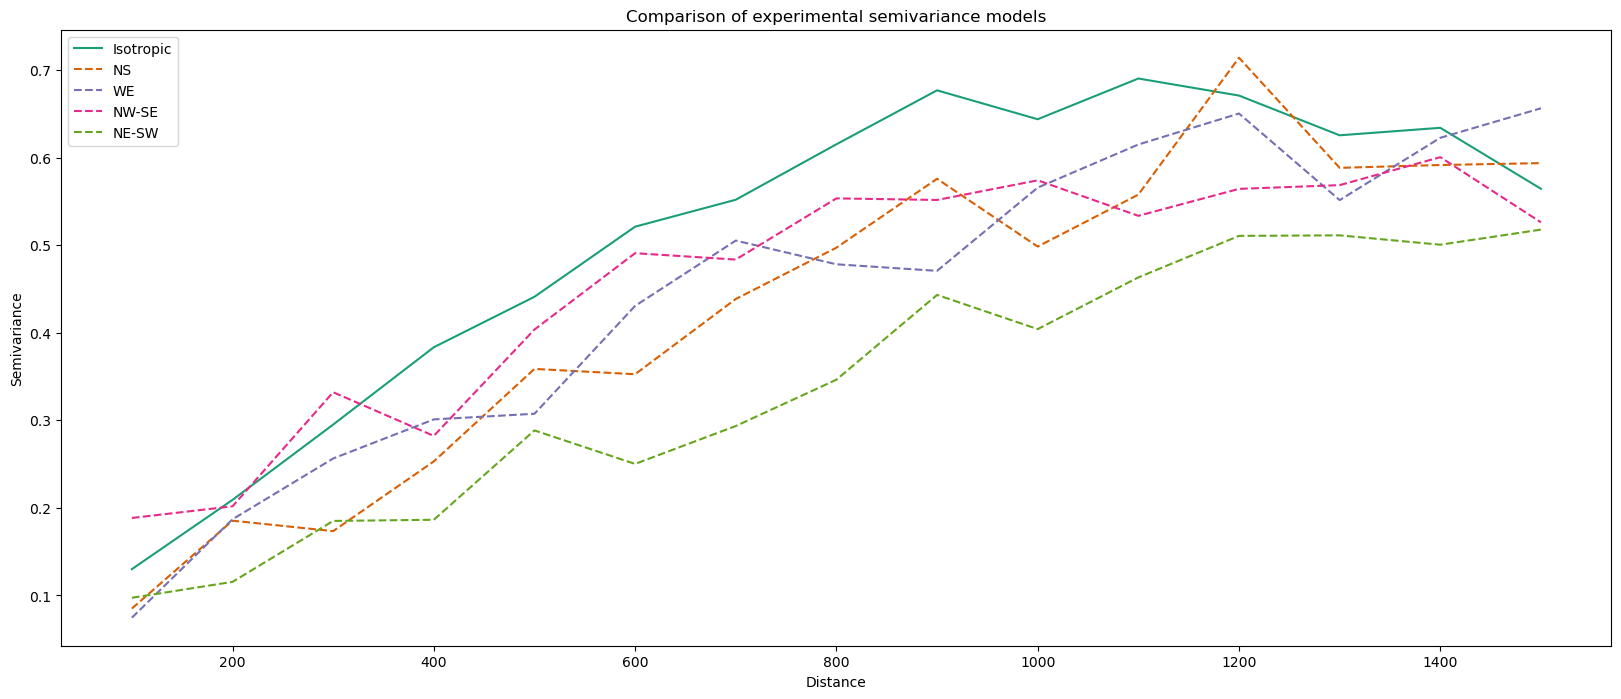

In [8]:
dirvar = DirectionalVariogram(input_array=df[['x', 'y', 'log-zinc']],
                              step_size=STEP_SIZE,
                              max_range=MAX_RANGE,
                              tolerance=0.1,
                              method='e')
dirvar.show()

We have five experimental variograms for further modeling. Let's build theoretical models from them.

In [9]:
MODEL_TYPE = 'spherical'
DIRECTIONS = ['ISO', 'NS', 'WE', 'NE-SW', 'NW-SE']

In [10]:
theoretical_models = {}
variograms = dirvar.get()

for direction in DIRECTIONS:
    theoretical_model = ptp.TheoreticalVariogram()
    theoretical_model.autofit(experimental_variogram=variograms[direction],
                              model_types=MODEL_TYPE)
    theoretical_models[direction] = theoretical_model

## 3. Create directional Ordinary Kriging models

With a set of directional variograms we will perform spatial interpolation over a defined grid.

In [11]:
grid = pd.read_csv(MEUSE_GRID, usecols=['x', 'y'])
grid.head()

,x,y
0,181180,333740
1,181140,333700
2,181180,333700
3,181220,333700
4,181100,333660


In [12]:
kriged_results = {}

for direction in DIRECTIONS:
    result = ptp.kriging(observations=df[['x', 'y', 'log-zinc']].values,
                         theoretical_model=theoretical_models[direction],
                         points=grid.values,
                         no_neighbors=16,
                         use_all_neighbors_in_range=True)
    result = pd.DataFrame(result, columns=['pred', 'err', 'x', 'y'])
    result = gpd.GeoDataFrame(result)
    result['geometry'] = gpd.points_from_xy(result['x'], result['y'])
    kriged_results[direction] = result

100%|██████████| 3103/3103 [00:00<00:00, 4310.58it/s]


In [13]:
kriged_results['ISO'].head()

,pred,err,x,y,geometry
0,6.526509,0.289442,181180.0,333740.0,POINT (181180.000 333740.000)
1,6.660548,0.201562,181140.0,333700.0,POINT (181140.000 333700.000)
2,6.528892,0.229987,181180.0,333700.0,POINT (181180.000 333700.000)
3,6.403988,0.258053,181220.0,333700.0,POINT (181220.000 333700.000)
4,6.807497,0.110891,181100.0,333660.0,POINT (181100.000 333660.000)


With all models calculated we can compare results of interpolation. We will show interpolation and variance errors across the models.

## 4. Compare interpolated results

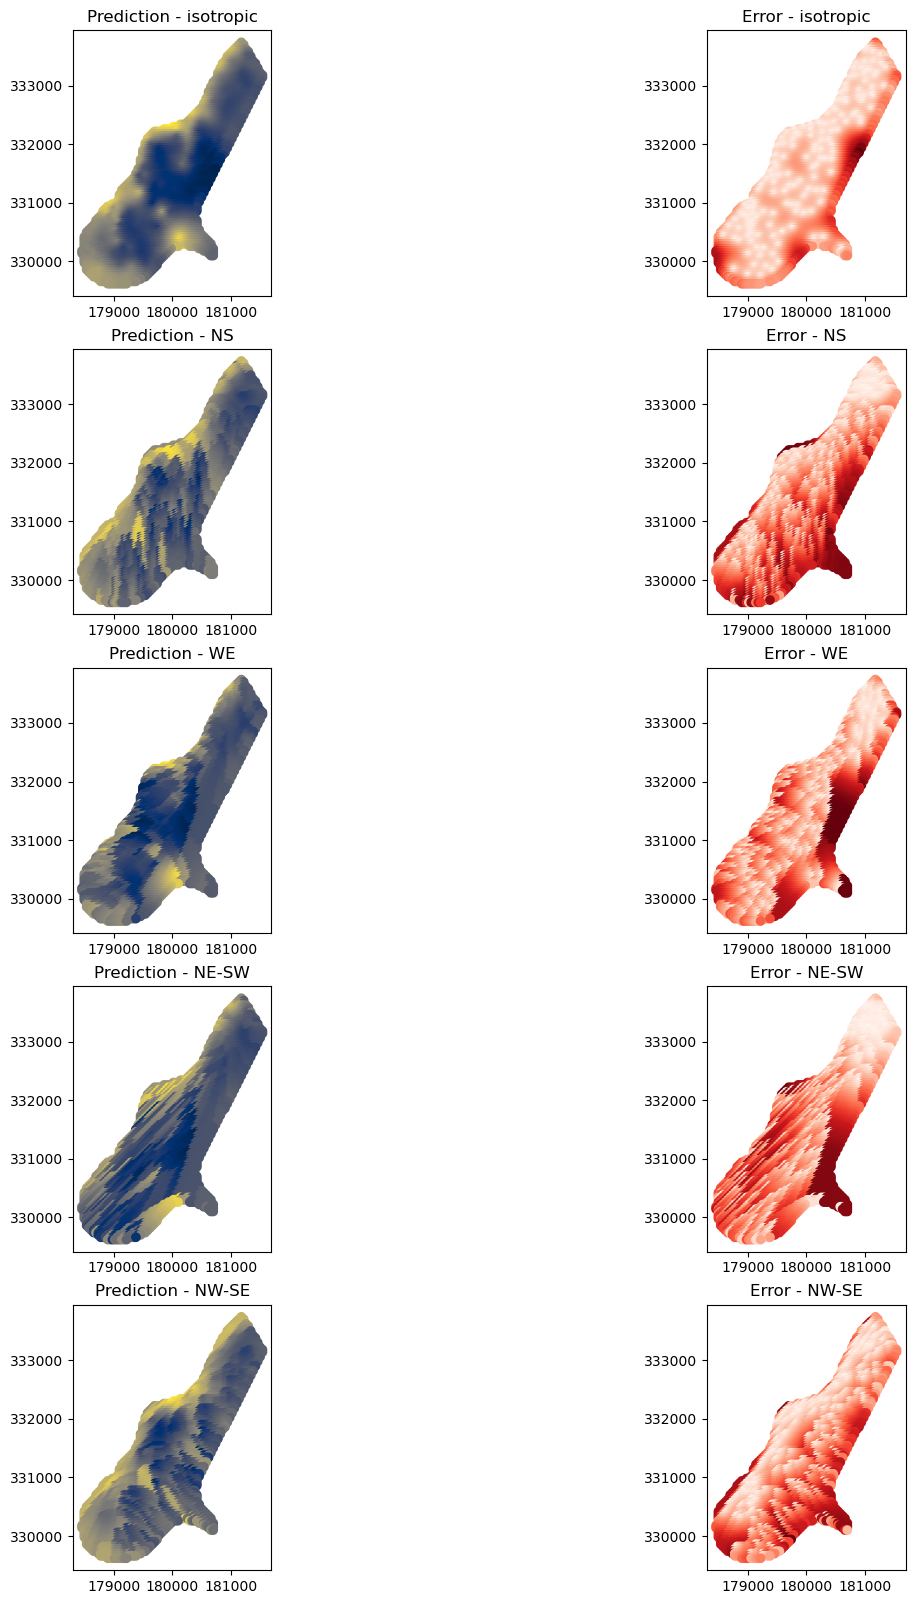

In [14]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

kriged_results['ISO'].plot(ax=ax[0, 0], column='pred', cmap='cividis')
kriged_results['ISO'].plot(ax=ax[0, 1], column='err', cmap='Reds')
ax[0, 0].set_title('Prediction - isotropic')
ax[0, 1].set_title('Error - isotropic')

kriged_results['NS'].plot(ax=ax[1, 0], column='pred', cmap='cividis')
kriged_results['NS'].plot(ax=ax[1, 1], column='err', cmap='Reds')
ax[1, 0].set_title('Prediction - NS')
ax[1, 1].set_title('Error - NS')

kriged_results['WE'].plot(ax=ax[2, 0], column='pred', cmap='cividis')
kriged_results['WE'].plot(ax=ax[2, 1], column='err', cmap='Reds')
ax[2, 0].set_title('Prediction - WE')
ax[2, 1].set_title('Error - WE')

kriged_results['NE-SW'].plot(ax=ax[3, 0], column='pred', cmap='cividis')
kriged_results['NE-SW'].plot(ax=ax[3, 1], column='err', cmap='Reds')
ax[3, 0].set_title('Prediction - NE-SW')
ax[3, 1].set_title('Error - NE-SW')

kriged_results['NW-SE'].plot(ax=ax[4, 0], column='pred', cmap='cividis')
kriged_results['NW-SE'].plot(ax=ax[4, 1], column='err', cmap='Reds')
ax[4, 0].set_title('Prediction - NW-SE')
ax[4, 1].set_title('Error - NW-SE')

plt.show()

Directional Kriging clearly shows the leading direction, and it's even more pronounced in the variance error maps. At the end, let's compare the mean of directional interpolations to the isotropic interpolation result:

In [15]:
mean_directional_results = (kriged_results['NS']['pred'] +
                            kriged_results['WE']['pred'] +
                            kriged_results['NE-SW']['pred'] +
                            kriged_results['NW-SE']['pred']) / 4

In [16]:
kriged_results['ISO']['mean_dir_pred'] = mean_directional_results

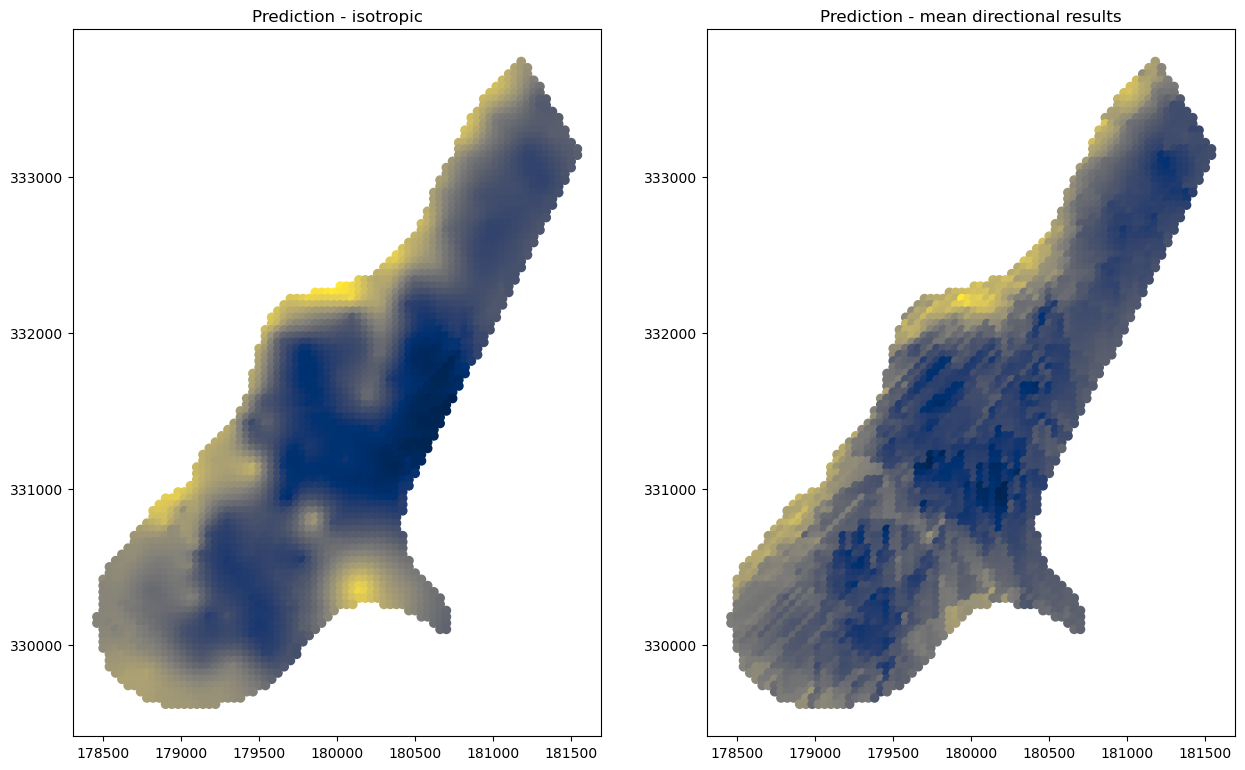

In [17]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 20))

kriged_results['ISO'].plot(ax=ax[0], column='pred', cmap='cividis')
ax[0].set_title('Prediction - isotropic')
kriged_results['ISO'].plot(ax=ax[1], column='mean_dir_pred', cmap='cividis')
ax[1].set_title('Prediction - mean directional results')
plt.show()

---